**Student Information**
- Name: 賴琮運
- Student ID: 112034571
- GitHub ID: ggbdmn
- Kaggle name: 112034571
- Kaggle private scoreboard snapshot: /img/pic0.png

In [1]:
import json
import pandas as pd
import numpy as np
import torch
import string
import nltk
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from transformers import AutoTokenizer, AutoModel
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from contractions import fix
import swifter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
import lightgbm as lgb

# Import Data with a fraction:

In [2]:
data = []
with open('tweet/tweets_DM.json', 'r') as f:
    for line in f:
        data.append(json.loads(line)) 
f.close()

emotion = pd.read_csv('tweet/emotion.csv')
data_identification = pd.read_csv('tweet/data_identification.csv')

df = pd.DataFrame(data)
_source = df['_source'].apply(lambda x: x['tweet'])
df = pd.DataFrame({
    'tweet_id': _source.apply(lambda x: x['tweet_id']),
    'hashtags': _source.apply(lambda x: x['hashtags']),
    'text': _source.apply(lambda x: x['text']),
})
df = df.merge(data_identification, on='tweet_id', how='left')

train_data = df[df['identification'] == 'train']
test_data = df[df['identification'] == 'test']

# Check if there is duplicated data.
train_data = train_data.merge(emotion, on='tweet_id', how='left')
train_data.drop_duplicates(subset=['text'], keep=False, inplace=True)

train_data_sample = train_data.sample(frac=0.2, random_state=42) # Due to the large scale of the data. The fraction was set to 0.5 for the result on Kaggle.
train_data_sample.to_pickle("train_dsample.pkl")
train_df = pd.read_pickle("train_dsample.pkl")

test_data.to_pickle("test_d.pkl")
test_df = pd.read_pickle("test_d.pkl")

In [4]:
train_df

,tweet_id,hashtags,text,identification,emotion
861298,0x29573d,[],@SuicideGirls I will feel high anywhere with t...,train,joy
1162037,0x33a0d6,[Unconscionable],@SenBobCorker I am a Democrat & I applaud your...,train,disgust
127464,0x22f649,[ReignCane],Tulsa showing me some love! <LH> #ReignCane @C...,train,trust
1216259,0x207fd5,[],@CNN Why now? Why not when obama was president...,train,surprise
630563,0x34d404,[],@jtonerv @rajivj @a2zUserGroup Is that a cardb...,train,joy
...,...,...,...,...,...
569918,0x317d0c,[],When you watch the charger game but you rememb...,train,sadness
1101307,0x3012f8,[hullfc],"Ok, tomorrow is effectively a quarter final an...",train,anticipation
1125339,0x321643,[],"@TheView Apple slices...salted. I know, <LH>",train,surprise
671004,0x1fdf98,[],Sometimes I am just so very <LH>,train,sadness


In [5]:
test_df

,tweet_id,hashtags,text,identification
2,0x28b412,[bibleverse],"Confident of your obedience, I write to you, k...",test
4,0x2de201,[],"""Trust is not the same as faith. A friend is s...",test
9,0x218443,"[materialism, money, possessions]",When do you have enough ? When are you satisfi...,test
30,0x2939d5,"[GodsPlan, GodsWork]","God woke you up, now chase the day #GodsPlan #...",test
33,0x26289a,[],"In these tough times, who do YOU turn to as yo...",test
...,...,...,...,...
1867525,0x2913b4,[],"""For this is the message that ye heard from th...",test
1867529,0x2a980e,[],"""There is a lad here, which hath five barley l...",test
1867530,0x316b80,"[mixedfeeling, butimTHATperson]",When you buy the last 2 tickets remaining for ...,test
1867531,0x29d0cb,[],I swear all this hard work gone pay off one da...,test


# Check the word frequencies in the text.

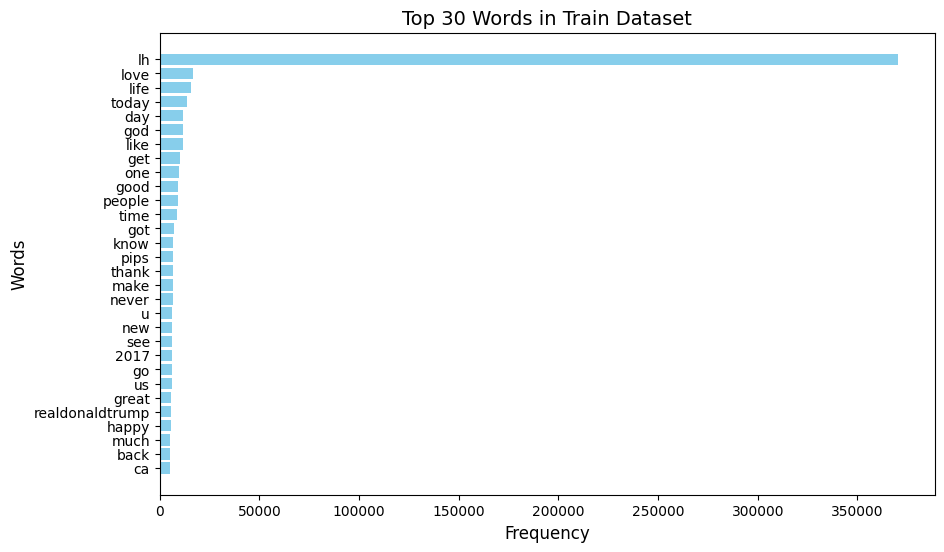

In [3]:
import matplotlib.pyplot as plt
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk



def tokenize_and_count(text_list):
    stop_words = set(stopwords.words('english'))
    words = []
    for text in text_list:
        tokens = word_tokenize(text.lower())
        words.extend([word for word in tokens if word.isalnum() and word not in stop_words])
    return Counter(words)

# Get word frequencies for train
train_word_counts = tokenize_and_count(train_data_sample['text'])

# Extract the top 30 words for each dataset
top_train_words = train_word_counts.most_common(30)

# Plot the word frequencies
def plot_word_frequencies(word_counts, title):
    words, counts = zip(*word_counts)
    plt.figure(figsize=(10, 6))
    plt.barh(words, counts, color='skyblue')
    plt.gca().invert_yaxis()
    plt.title(title, fontsize=14)
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel('Words', fontsize=12)
    plt.show()

# Plot for train dataset
plot_word_frequencies(top_train_words, "Top 30 Words in Train Dataset")

# Check the emotion distribution of the data.

emotion
joy             103001
anticipation     49420
trust            41056
sadness          38446
disgust          27636
fear             12711
surprise          9529
anger             8037
Name: count, dtype: int64


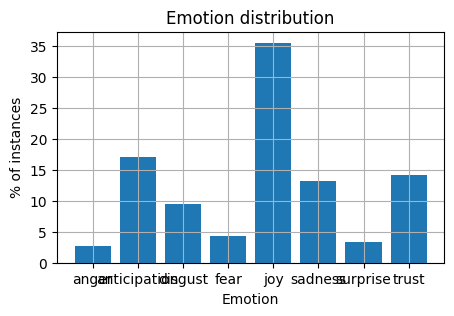

In [6]:
train_df.groupby(['emotion']).count()['text']
print(train_df['emotion'].value_counts())

# the histogram of the data
labels = train_df['emotion'].unique()
post_total = len(train_df)
df1 = train_df.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show()

# Since the distribution is dramatic, try to resample the emotions to the same amount.

In [8]:
from sklearn.utils import resample

minority_classes = train_df['emotion'].value_counts().min()
balanced_df = pd.concat([
    resample(train_df[train_df['emotion'] == emotion], 
             replace=False, 
             n_samples=minority_classes, 
             random_state=42)
    for emotion in train_df['emotion'].unique()
])

train_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(train_df['emotion'].value_counts())

emotion
anticipation    8037
fear            8037
surprise        8037
joy             8037
sadness         8037
disgust         8037
trust           8037
anger           8037
Name: count, dtype: int64


# Preprocess the data.

In [9]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import wordnet
import emoji
import re

stop_words = set(stopwords.words('english'))

# emoji dictionary to change emojis to texts
emoji_dict = {
    '😂': '[joy]', '❤️': '[love]', '😍': '[adoration]', '😭': '[cry]',
    '❤': '[care]', '😊': '[happy]', '🙏': '[pray]', '😘': '[kiss]',
    '💕': '[love_each_other]', '🔥': '[fire]', '😩': '[weary]',
    '🤔': '[think]', '💯': '[perfect]', '💙': '[loyalty]',
    '🙄': '[annoyed]', '😁': '[happy]', '🙌': '[celebrate]',
    '🙏🏾': '[pray]', '👍': '[approve]', '🙏🏽': '[pray]'
}

# Define a dictionary for common Twitter abbreviations/slangs
slang_dict = {
    "lol": "laugh out_loud",
    "u": "you",
    "idk": "I do not know",
    "omg": "oh my god",
    "btw": "by the way",
    "lmao": "laugh my_ass_off",
    "lmfao": "laugh my_ass_off",
    "fyi": "for your information",
    "brb": "be right back"
    
}

def preprocess_text(text):
    # 替換 emoji
    for emj, keyword in emoji_dict.items():
        text = text.replace(emj, keyword)
    text = emoji.replace_emoji(text, replace='')  # Replace emojis
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove weblinks
    text = re.sub(r'RT[\s]+', '', text)  # Remove Retweet code
    text = text.replace('<LH>', '') # Remove Select code
    text = re.sub(r'\@\w+|\#', '', text)  # Remove @user and hashtags
    #text = re.sub(r"[^a-zA-Z0-9\s]", '', text)  # Remove special characters
    text = text.lower() # Uncapitalize every word.
    text = re.sub(r'[^\w\s!?]', '', text) # Remove punctuation marks.
    text = re.sub(r'not\s+(\w+)', r'not_\1', text) # Replace "not xxx" to "not_xxx".
    
    wds = text.split() 
    tweet = " ".join([slang_dict[wd.lower()] if wd.lower() in slang_dict else wd for wd in wds]) # Replace slangs with texts.
    
    text = fix(text) # Unabbreviate acronyms.

    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(wd) for wd in text.split()]) # Convert to base verb.
    
    text = text.strip()
    words = word_tokenize(text)
    return ' '.join([word for word in words]) # Clean space.

# Preprocess train and test dataset
train_df['clean_text'] = train_df['text'].swifter.apply(preprocess_text)
test_df['clean_text'] = test_df['text'].swifter.apply(preprocess_text)

# Redistribute the train dataset
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

Pandas Apply:   0%|          | 0/64296 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/411972 [00:00<?, ?it/s]

# W2V to generate feature by cleaned text.

In [10]:
#w2v preprocessing
def w2v_preprocess_text(text):
    words = word_tokenize(text)
    return ' '.join([word for word in words if word not in stop_words])
    
train_df['w2v_text'] = train_df['clean_text'].swifter.apply(w2v_preprocess_text)
test_df['w2v_text'] = test_df['clean_text'].swifter.apply(w2v_preprocess_text)

from gensim.models import Word2Vec
import numpy as np

train_sentences = train_df['w2v_text'].apply(lambda x: x.split()).tolist()
test_sentences = test_df['w2v_text'].apply(lambda x: x.split()).tolist()

w2v_model = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=2, workers=4)

def sentence_to_vector(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

train_text_vectors = np.array([sentence_to_vector(sent, w2v_model) for sent in train_sentences])
test_text_vectors = np.array([sentence_to_vector(sent, w2v_model) for sent in test_sentences])

Pandas Apply:   0%|          | 0/64296 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/411972 [00:00<?, ?it/s]

# TFIDF to generate feature by hashtags.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

train_df['hashtags'] = train_df['hashtags'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
test_df['hashtags'] = test_df['hashtags'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')

tfidf = TfidfVectorizer(max_features=500, stop_words='english')
tfidf_train = tfidf.fit_transform(train_df['hashtags'])
tfidf_test = tfidf.transform(test_df['hashtags'])

# Utilize Distil BERT to generate feature by clean text.

In [12]:
cache_path = "C:\\Users\\t1070\\.cache\\huggingface\\transformers"

from transformers import AutoTokenizer, AutoModel

MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, cache_dir=cache_path)
model = AutoModel.from_pretrained(MODEL_NAME, cache_dir=cache_path)

model.to('cuda')

def extract_bert_embeddings(text_series, batch_size=32):
    def process_batch(batch_texts):
        encodings = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
        for key in encodings:
            encodings[key] = encodings[key].to('cuda')
        outputs = model(**encodings)
        return outputs.last_hidden_state[:, 0, :].detach().cpu().numpy()

    embeddings = (
        text_series
        .swifter.apply(lambda text: process_batch([text])[0]) 
        .to_numpy()
    )
    return np.stack(embeddings)

bert_train = extract_bert_embeddings(train_df['clean_text'])
bert_test = extract_bert_embeddings(test_df['clean_text'])

Pandas Apply:   0%|          | 0/64296 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/411972 [00:00<?, ?it/s]

# Utilize SentimentIntensityAnalyzer to generate feature.

In [13]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
def extract_sentiment_features(text_series):
    sentiment_scores = text_series.swifter.apply(lambda text: sid.polarity_scores(text))
    return pd.DataFrame(list(sentiment_scores))

sentiment_train = extract_sentiment_features(train_df['text'])
sentiment_test = extract_sentiment_features(test_df['text'])

Pandas Apply:   0%|          | 0/64296 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/411972 [00:00<?, ?it/s]

# Combine all the features.

In [14]:
from scipy.sparse import hstack

train_features = torch.cat([
    torch.tensor(tfidf_train.toarray(), dtype=torch.float32).to('cuda'),
    torch.tensor(train_text_vectors, dtype=torch.float32).to('cuda'),
    torch.tensor(bert_train, dtype=torch.float32).to('cuda'),
    torch.tensor(sentiment_train.values.astype(np.float32), dtype=torch.float32).to('cuda')
], dim=1)

test_features = torch.cat([
    torch.tensor(tfidf_test.toarray(), dtype=torch.float32).to('cuda'),
    torch.tensor(test_text_vectors, dtype=torch.float32).to('cuda'),
    torch.tensor(bert_test, dtype=torch.float32).to('cuda'),
    torch.tensor(sentiment_test.values.astype(np.float32), dtype=torch.float32).to('cuda')
], dim=1)

# Prepare the data for training.

In [15]:
# Label encoding the emotions
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['emotion'])

# Split the train datasets for training and validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    train_features,  
    y_train, 
    test_size=0.2,
    random_state=42,
    stratify=y_train  
)


# Train by LSTM with attention

In [17]:
import os

# Set the directory for cache.
torch_cache_dir = "C:\\Users\\t1070\\.cache\\torch\\cache"
os.environ['TORCH_HOME'] = torch_cache_dir  

torch.cuda.empty_cache()

from torch import nn

class LSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    
    def forward(self, x):
        # Ensure x is 3D: [batch_size, sequence_length, features]
        if x.dim() == 2:
            x = x.unsqueeze(1)  # Add sequence dimension if missing
        
        lstm_out, _ = self.lstm(x)
        
        # Compute attention scores
        attention_scores = self.attention(lstm_out).squeeze(-1)
        attention_weights = torch.softmax(attention_scores, dim=1)
        
        # Weighted sum of LSTM outputs
        attended_output = torch.sum(attention_weights.unsqueeze(-1) * lstm_out, dim=1)
        
        return self.fc(attended_output)

# LSTM+Attention model
# Construct DataLoader
batch_size = 16
accumulation_steps = 2
num_epochs = 7

# Create dataset and loader
train_dataset = TensorDataset(
    torch.tensor(X_train_split, dtype=torch.float32), 
    torch.tensor(y_train_split, dtype=torch.long)
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss, and optimizer
lstm_attention_model = LSTMWithAttention(
    input_dim=X_train_split.shape[1], 
    hidden_dim=64,  # Reduced hidden dimension 
    output_dim=len(label_encoder.classes_)
).to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_attention_model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    lstm_attention_model.train()
    epoch_loss = 0.0
    
    for i, (batch_features, batch_labels) in enumerate(train_loader):
        batch_features = batch_features.to('cuda')
        batch_labels = batch_labels.to('cuda')
        
        # Forward pass
        outputs = lstm_attention_model(batch_features)
        
        # Compute loss
        loss = criterion(outputs, batch_labels) / accumulation_steps
        
        # Backward pass
        loss.backward()
        
        # Update weights
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {epoch_loss / len(train_loader)}")

torch.cuda.empty_cache()

C:\Users\t1070\AppData\Local\Temp\ipykernel_39980\4062042642.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(X_train_split, dtype=torch.float32),


Epoch 1/7, Average Loss: 0.8738586334752072
Epoch 2/7, Average Loss: 0.8162243988521363
Epoch 3/7, Average Loss: 0.7888451982434392
Epoch 4/7, Average Loss: 0.7686200263989658
Epoch 5/7, Average Loss: 0.7526135037698048
Epoch 6/7, Average Loss: 0.7380433976742936
Epoch 7/7, Average Loss: 0.7228625562383821


# Plot Classification Report and Confusion Matrix

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

# Validation loop
val_dataset = TensorDataset(
    torch.tensor(X_val_split, dtype=torch.float32), 
    torch.tensor(y_val_split, dtype=torch.long)
)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

lstm_attention_model.eval()
val_preds = []
val_true = []
with torch.no_grad():
    for batch_features, batch_labels in val_loader:
        batch_features = batch_features.to('cuda')
        outputs = lstm_attention_model(batch_features)
        batch_preds = torch.argmax(outputs, dim=1).cpu().numpy()
        val_preds.extend(batch_preds)
        val_true.extend(batch_labels.numpy())

print("LSTM Confusion Matrix:")
print(confusion_matrix(val_true, val_preds))
print("\nLSTM Classification Report:")
print(classification_report(val_true, val_preds))

C:\Users\t1070\AppData\Local\Temp\ipykernel_39980\1471479750.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(X_val_split, dtype=torch.float32),


LSTM Confusion Matrix:
[[694  67 180 195  93 214  75  89]
 [ 50 869  46 119 147  92  66 218]
 [182  71 556 219  92 286 117  85]
 [ 82 123  97 860 125 124 100  97]
 [ 61 188  49 165 600  88  76 381]
 [179  82 204 256 100 559 131  96]
 [144  93 177 252 151 186 481 124]
 [ 53 244  58 127 239  91  69 726]]

LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.43      0.45      1607
           1       0.50      0.54      0.52      1607
           2       0.41      0.35      0.37      1608
           3       0.39      0.53      0.45      1608
           4       0.39      0.37      0.38      1608
           5       0.34      0.35      0.34      1607
           6       0.43      0.30      0.35      1608
           7       0.40      0.45      0.42      1607

    accuracy                           0.42     12860
   macro avg       0.42      0.42      0.41     12860
weighted avg       0.42      0.42      0.41     12860



# Generate test dataset results.

In [19]:
test_features_tensor = torch.tensor(test_features, dtype=torch.float32).to('cuda')

# Predict on test set
lstm_attention_model.eval()
with torch.no_grad():
    torch.cuda.empty_cache()
    y_test_pred = torch.argmax(lstm_attention_model(test_features_tensor), dim=1).cpu().numpy()

# Inverse transform predictions
test_df['emotion'] = label_encoder.inverse_transform(y_test_pred)

# Output submission
submission = test_df[['tweet_id', 'emotion']]
submission.to_csv('lstm_submission_final.csv', index=False)


C:\Users\t1070\AppData\Local\Temp\ipykernel_39980\235401172.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_features_tensor = torch.tensor(test_features, dtype=torch.float32).to('cuda')
